# Complete ML Analysis: Optimal Streaming Time Prediction







---
<a id='1'></a>
## 1 Setup and Data Loading

Import libraries and load the Twitch streaming dataset.

In [3]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.cluster import KMeans

# Configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("COMPREHENSIVE ML ANALYSIS - OPTIMAL STREAMING TIME PREDICTION")
print("="*80)
print(f"✓ Libraries imported successfully")
print(f"✓ Random seed set to {RANDOM_STATE}")
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

COMPREHENSIVE ML ANALYSIS - OPTIMAL STREAMING TIME PREDICTION
✓ Libraries imported successfully
✓ Random seed set to 42
Start time: 2025-12-02 20:06:46


In [4]:
# Load the Twitch dataset
path = "100k_a.csv"
colnames = ["user_id", "stream_id", "streamer_username", "time_start", "time_stop"]
df = pd.read_csv(path, header=None, names=colnames)
df = df.sort_values("time_start").reset_index(drop=True)

print(f"✓ Loaded: {df.shape}")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nDataset Overview:")
print(f"  Viewing sessions: {len(df):,}")
print(f"  Unique viewers: {df['user_id'].nunique():,}")
print(f"  Unique streamers: {df['streamer_username'].nunique():,}")
print(f"  Time span: {(df['time_stop'].max() - df['time_start'].min()) / 144:.1f} days")

df.head(10)

✓ Loaded: (3051733, 5)
  Memory usage: 261.49 MB

Dataset Overview:
  Viewing sessions: 3,051,733
  Unique viewers: 100,000
  Unique streamers: 162,625
  Time span: 42.7 days


,user_id,stream_id,streamer_username,time_start,time_stop
0,11587,33827617344,miltontpike1,0,5
1,13763,33827755632,rekinss,0,1
2,13763,33827475024,airon29,0,1
3,13763,33827351664,tonytubo,0,1
4,13763,33827169440,eliasmerk,0,1
5,13763,33825519552,asia_games_it,0,1
6,13763,33825490400,lofacciopervoiii,0,1
7,51143,33828336960,iamcristinini,0,4
8,13763,33825461136,giginopane81,0,1
9,60340,33825983088,tsm_viss,0,3


---
<a id='2'></a>
## 2 Exploratory Data Analysis

Understanding the dataset characteristics before modeling.

SESSION DURATION ANALYSIS
Mean: 31.42 minutes
Median: 10.00 minutes
Std: 42.58 minutes


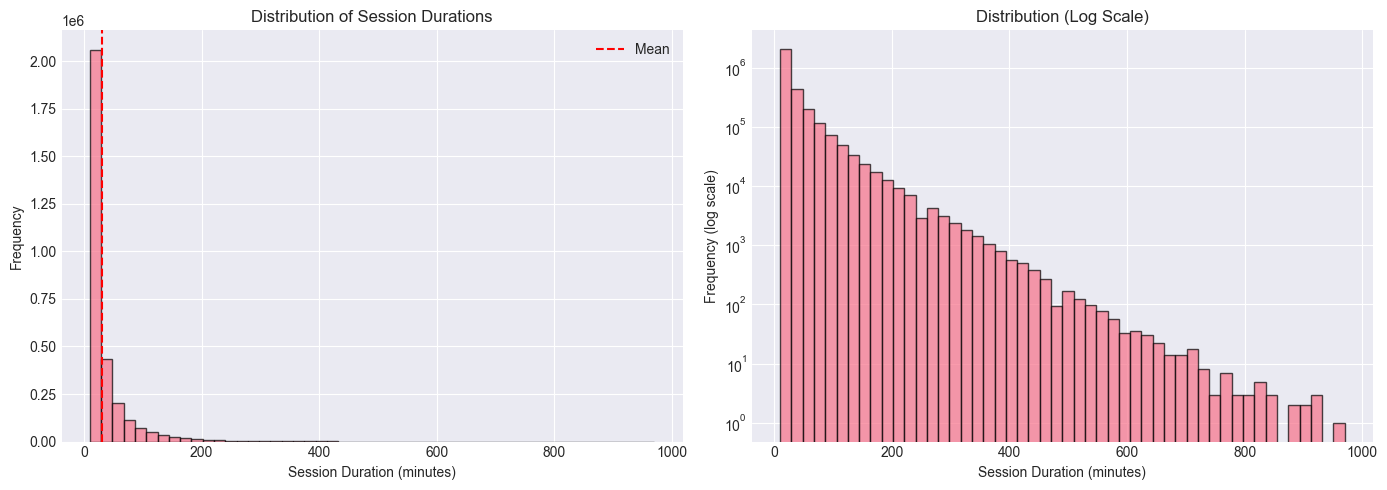

In [5]:
# Add temporal features
df['hour'] = (df['time_start'] % 144) // 6
df['day'] = df['time_start'] // 144
df['session_duration'] = df['time_stop'] - df['time_start']
df['duration_minutes'] = df['session_duration'] * 10

print("="*80)
print("SESSION DURATION ANALYSIS")
print("="*80)
print(f"Mean: {df['duration_minutes'].mean():.2f} minutes")
print(f"Median: {df['duration_minutes'].median():.2f} minutes")
print(f"Std: {df['duration_minutes'].std():.2f} minutes")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(df['duration_minutes'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Session Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Session Durations')
axes[0].axvline(df['duration_minutes'].mean(), color='red', linestyle='--', label='Mean')
axes[0].legend()

axes[1].hist(df['duration_minutes'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Session Duration (minutes)')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_title('Distribution (Log Scale)')
axes[1].set_yscale('log')
plt.tight_layout()
plt.show()

In [6]:
# Streamer Analysis
print("="*80)
print("STREAMER ANALYSIS")
print("="*80)

streamer_sessions = df.groupby('streamer_username').size()
streamer_viewers = df.groupby('streamer_username')['user_id'].nunique()
streamer_time = df.groupby('streamer_username')['duration_minutes'].sum()

print(f"Mean sessions per streamer: {streamer_sessions.mean():.2f}")
print(f"Mean unique viewers per streamer: {streamer_viewers.mean():.2f}")

# Categorize by size
percentile_33 = np.percentile(streamer_viewers, 33)
percentile_67 = np.percentile(streamer_viewers, 67)

def categorize_streamer_size(viewer_count):
    if viewer_count <= percentile_33:
        return 'Small'
    elif viewer_count <= percentile_67:
        return 'Mid-sized'
    else:
        return 'Large'

streamer_df = pd.DataFrame({
    'streamer': streamer_viewers.index,
    'unique_viewers': streamer_viewers.values,
    'total_sessions': streamer_sessions.values,
    'total_minutes': streamer_time.values
})
streamer_df['size_category'] = streamer_df['unique_viewers'].apply(categorize_streamer_size)

print(f"\n🏆 Streamer Size Distribution:")
size_counts = streamer_df['size_category'].value_counts()
for size in ['Small', 'Mid-sized', 'Large']:
    count = size_counts.get(size, 0)
    pct = (count / len(streamer_df)) * 100
    print(f"  {size}: {count:,} streamers ({pct:.1f}%)")
    
print(f"\n⚠️  High proportion of small streamers → stratified approach needed!")

# Save for later
streamer_df.to_csv('streamer_categories.csv', index=False)
print(f"✓ Saved streamer categories")

STREAMER ANALYSIS
Mean sessions per streamer: 18.77
Mean unique viewers per streamer: 9.26

🏆 Streamer Size Distribution:
  Small: 89,656 streamers (55.1%)
  Mid-sized: 25,640 streamers (15.8%)
  Large: 47,329 streamers (29.1%)

⚠️  High proportion of small streamers → stratified approach needed!
✓ Saved streamer categories


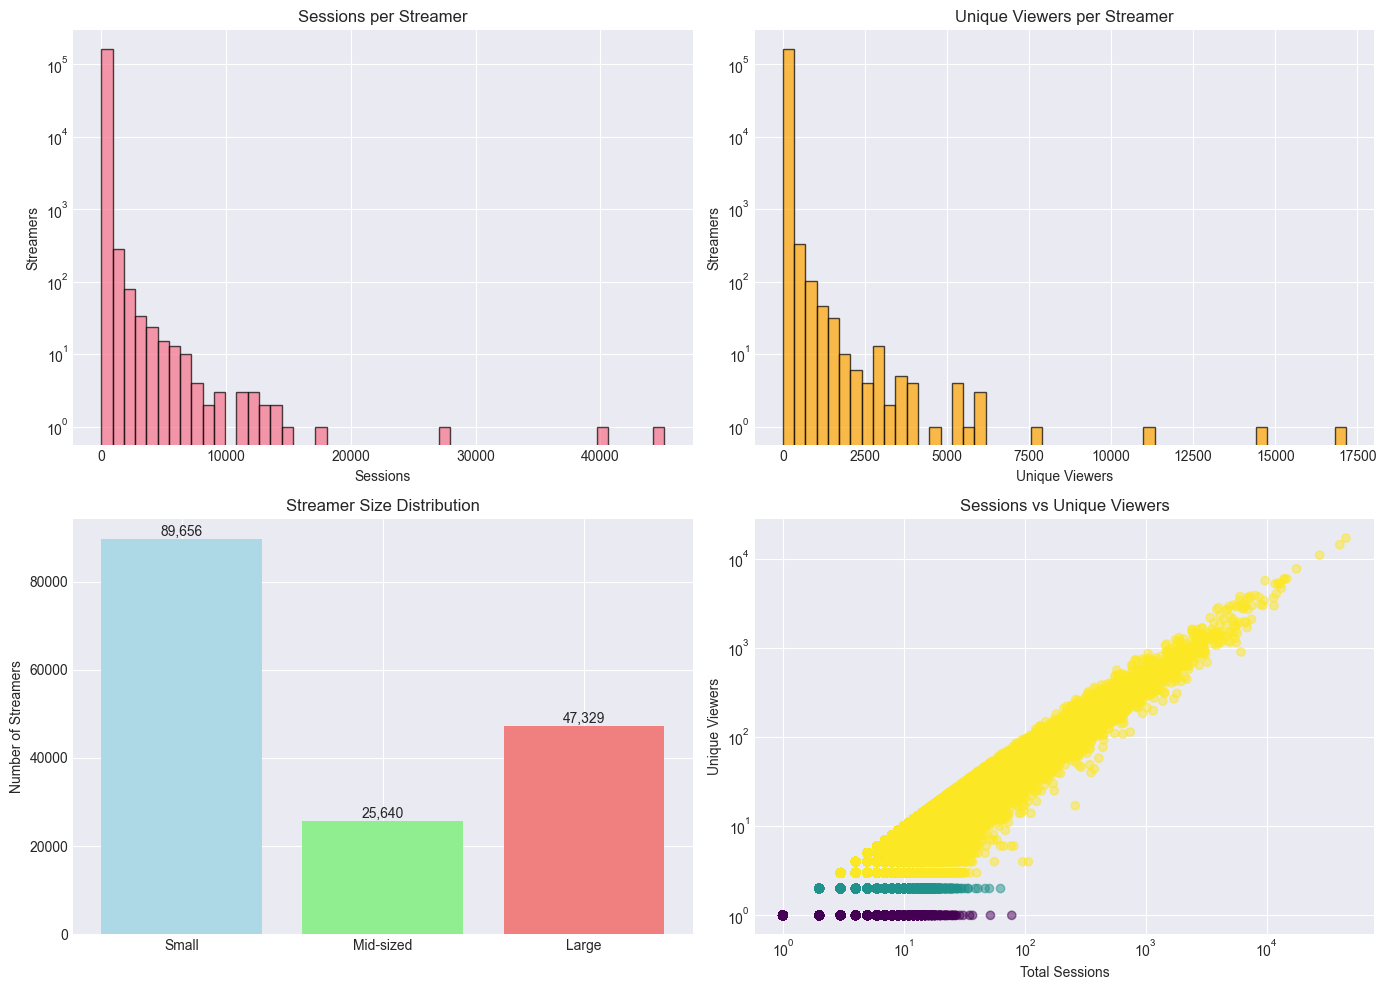

In [7]:
# Visualize streamer analysis
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(streamer_sessions, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Sessions')
axes[0, 0].set_ylabel('Streamers')
axes[0, 0].set_title('Sessions per Streamer')
axes[0, 0].set_yscale('log')

axes[0, 1].hist(streamer_viewers, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Unique Viewers')
axes[0, 1].set_ylabel('Streamers')
axes[0, 1].set_title('Unique Viewers per Streamer')
axes[0, 1].set_yscale('log')

size_order = ['Small', 'Mid-sized', 'Large']
size_data = streamer_df['size_category'].value_counts().reindex(size_order)
axes[1, 0].bar(size_order, size_data.values, color=['lightblue', 'lightgreen', 'lightcoral'])
axes[1, 0].set_ylabel('Number of Streamers')
axes[1, 0].set_title('Streamer Size Distribution')
for i, v in enumerate(size_data.values):
    axes[1, 0].text(i, v, f'{v:,}', ha='center', va='bottom')

axes[1, 1].scatter(streamer_df['total_sessions'], streamer_df['unique_viewers'], 
                   alpha=0.5, c=streamer_df['size_category'].map({'Small': 0, 'Mid-sized': 1, 'Large': 2}),
                   cmap='viridis')
axes[1, 1].set_xlabel('Total Sessions')
axes[1, 1].set_ylabel('Unique Viewers')
axes[1, 1].set_title('Sessions vs Unique Viewers')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

TEMPORAL PATTERNS

Peak Hours:
  Hour 21: 181,716 sessions
  Hour 20: 175,651 sessions
  Hour 22: 174,608 sessions
  Hour 19: 166,021 sessions
  Hour 23: 161,091 sessions


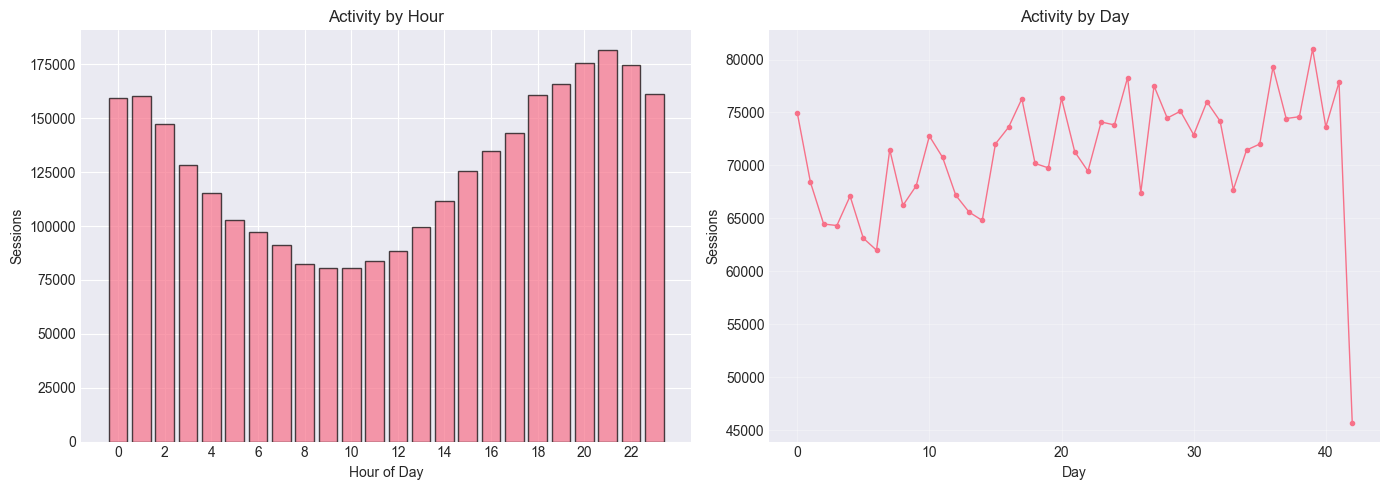

In [8]:
# Temporal patterns
hourly_activity = df.groupby('hour').size()
daily_activity = df.groupby('day').size()

print("="*80)
print("TEMPORAL PATTERNS")
print("="*80)
print(f"\nPeak Hours:")
top_hours = hourly_activity.sort_values(ascending=False).head(5)
for hour, count in top_hours.items():
    print(f"  Hour {hour:2d}: {count:,} sessions")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(24), [hourly_activity.get(h, 0) for h in range(24)], 
            edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Sessions')
axes[0].set_title('Activity by Hour')
axes[0].set_xticks(range(0, 24, 2))

axes[1].plot(daily_activity.index, daily_activity.values, marker='o', linewidth=1, markersize=3)
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Sessions')
axes[1].set_title('Activity by Day')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
<a id='3'></a>
## 3 Compute Hourly Concurrent Viewer Counts

Calculate how many concurrent viewers each streamer had during each hour.

In [9]:
print("="*80)
print("COMPUTING HOURLY CONCURRENT VIEWERS")
print("="*80)

def compute_hourly_viewers(df):
    """Compute concurrent viewer count for each streamer-hour-day."""
    print("Processing hourly viewer counts...")
    
    hourly_records = []
    
    for idx, row in df.iterrows():
        if idx % 10000 == 0:
            print(f"  Processed {idx:,} / {len(df):,} records", end='\r')
        
        user = row['user_id']
        streamer = row['streamer_username']
        start_period = row['time_start']
        stop_period = row['time_stop']
        
        # Convert to hours
        start_hour_period = start_period // 6
        stop_hour_period = stop_period // 6
        
        # Get all hours this session spans
        for hour_period in range(start_hour_period, stop_hour_period + 1):
            day = hour_period // 24
            hour = hour_period % 24
            
            hourly_records.append({
                'streamer': streamer,
                'day': day,
                'hour': hour,
                'user_id': user
            })
    
    print(f"\n  Processed {len(df):,} / {len(df):,} records")
    
    hourly_df = pd.DataFrame(hourly_records)
    hourly_viewers = hourly_df.groupby(['streamer', 'day', 'hour'])['user_id'].nunique().reset_index()
    hourly_viewers.columns = ['streamer', 'day', 'hour', 'viewer_count']
    
    print(f"  ✓ Created {len(hourly_viewers):,} hourly records")
    return hourly_viewers

hourly_data = compute_hourly_viewers(df)
hourly_data.head(10)

COMPUTING HOURLY CONCURRENT VIEWERS
Processing hourly viewer counts...
  Processed 3,050,000 / 3,051,733 records
  Processed 3,051,733 / 3,051,733 records
  ✓ Created 1,656,050 hourly records


,streamer,day,hour,viewer_count
0,0007_hot_kelly_tv,36,5,1
1,0007_hot_kelly_tv,36,6,1
2,0007_hot_kelly_tv,38,6,1
3,000aikia000,10,8,1
4,0011am,30,1,1
5,0011am,30,2,1
6,0011am,30,3,1
7,001_ssmashh_100,3,15,1
8,001_ssmashh_100,3,20,1
9,001_ssmashh_100,4,15,1


---
<a id='4'></a>
## 4 Train-Test Split 



In [16]:
TRAIN_DAYS = 34
max_day = hourly_data['day'].max()

train_data = hourly_data[hourly_data['day'] < TRAIN_DAYS].copy()
test_data = hourly_data[hourly_data['day'] >= TRAIN_DAYS].copy()

# Merge with streamer categories
train_data = train_data.merge(
    streamer_df[['streamer', 'size_category']], 
    left_on='streamer', 
    right_on='streamer', 
    how='left'
)
test_data = test_data.merge(
    streamer_df[['streamer', 'size_category']], 
    left_on='streamer', 
    right_on='streamer', 
    how='left'
)

print("="*80)
print("TEMPORAL TRAIN-TEST SPLIT")
print("="*80)
print(f"Training: Days 0-{TRAIN_DAYS-1} ({TRAIN_DAYS} days)")
print(f"Testing:  Days {TRAIN_DAYS}-{max_day} ({max_day-TRAIN_DAYS+1} days)")
print(f"\nTrain records: {len(train_data):,}")
print(f"Test records:  {len(test_data):,}")

print(f"\nTrain data by size:")
for size in ['Small', 'Mid-sized', 'Large']:
    count = (train_data['size_category'] == size).sum()
    pct = (count / len(train_data)) * 100
    print(f"  {size}: {count:,} records ({pct:.1f}%)")

TEMPORAL TRAIN-TEST SPLIT
Training: Days 0-33 (34 days)
Testing:  Days 34-42 (9 days)

Train records: 1,314,715
Test records:  341,335

Train data by size:
  Small: 153,886 records (11.7%)
  Mid-sized: 90,351 records (6.9%)
  Large: 1,070,478 records (81.4%)


---
<a id='5'></a>
## 5 Baseline Method

Test simple baseline approaches before ML models.

In [ ]:
# Define evaluation functions
def evaluate_recommendations(predictions, actuals, k=5):
    """Evaluate recommendation quality."""
    hit_rates, ndcgs, viewer_uplifts = [], [], []
    
    for streamer in predictions:
        if streamer not in actuals or len(actuals[streamer]) == 0:
            continue
        
        pred_hours = [h for h, _ in sorted(predictions[streamer], key=lambda x: x[1], reverse=True)[:k]]
        actual_sorted = sorted(actuals[streamer], key=lambda x: x[1], reverse=True)
        actual_hours = [h for h, _ in actual_sorted[:k]]
        actual_dict = {h: v for h, v in actual_sorted}
        
        # Hit rate
        hits = len(set(pred_hours) & set(actual_hours))
        hit_rates.append(hits / k)
        
        # NDCG
        dcg = sum([(1 if hour in actual_hours else 0) / np.log2(i + 2) for i, hour in enumerate(pred_hours)])
        idcg = sum([1 / np.log2(i + 2) for i in range(min(k, len(actual_hours)))])
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcgs.append(ndcg)
        
        # Viewer uplift
        pred_viewers = np.mean([actual_dict.get(h, 0) for h in pred_hours])
        random_viewers = np.mean([v for _, v in actuals[streamer]])
        uplift = pred_viewers - random_viewers
        viewer_uplifts.append(uplift)
    
    return {
        'hit_rate': np.mean(hit_rates),
        'ndcg': np.mean(ndcgs),
        'viewer_uplift': np.mean(viewer_uplifts),
        'coverage': len(hit_rates) / len(predictions)
    }

def evaluate_by_size(predictions, actuals, size_data, k=5):
    """Evaluate stratified by streamer size."""
    results = {}
    for size in ['Small', 'Mid-sized', 'Large']:
        streamers_in_size = set(size_data[size_data['size_category'] == size]['streamer'].unique())
        size_predictions = {s: p for s, p in predictions.items() if s in streamers_in_size}
        size_actuals = {s: a for s, a in actuals.items() if s in streamers_in_size}
        
        if len(size_predictions) > 0:
            results[size] = evaluate_recommendations(size_predictions, size_actuals, k)
        else:
            results[size] = {'hit_rate': 0, 'ndcg': 0, 'viewer_uplift': 0, 'coverage': 0}
    return results

# Prepare test actuals
grouped = test_data.groupby(['streamer', 'hour'])['viewer_count'].mean().reset_index()

test_actuals = {}
for streamer in grouped['streamer'].unique():
    streamer_data = grouped[grouped['streamer'] == streamer]
    test_actuals[streamer] = list(zip(streamer_data['hour'], streamer_data['viewer_count']))

print(f" Test actuals prepared for {len(test_actuals):,} streamers")




✓ Test actuals prepared for 66,673 streamers


In [19]:
#Baseline
print("="*80)
print("BASELINE: COMPETITION-ADJUSTED HOURS")
print("="*80)

platform_peak = train_data.groupby('hour')['viewer_count'].sum().sort_values(ascending=False)

# Calculate competition metrics
competition = train_data.groupby(['day', 'hour']).agg({
    'viewer_count': 'sum',
    'streamer': 'nunique'
}).reset_index()

# Ratio = total viewers / number of streamers (viewers per streamer)
competition['ratio'] = competition['viewer_count'] / (competition['streamer'] + 1)
competition_by_hour = competition.groupby('hour')['ratio'].mean().sort_values(ascending=False)

print(f"Best competition-adjusted hours: {competition_by_hour.head(10).index.tolist()}")

# Get streamer tiers
streamer_tiers = test_data.groupby('streamer')['size_category'].first()

# Competition-aware predictions tailored by streamer size
competition_predictions = {}
for streamer in test_actuals:
    tier = streamer_tiers.get(streamer, 'Mid-sized')
    
    if tier == 'Small':
        # Small streamers
        tier_scores = competition_by_hour.copy()
        peak_hours = platform_peak.head(3).index
        for h in peak_hours:
            if h in tier_scores.index:
                tier_scores[h] *= 0.5  # Penalize peak for small streamers
    elif tier == 'Large':
        # Large streamers
        tier_scores = platform_peak / (competition.groupby('hour')['streamer'].mean() + 1)
    else:
        # Mid-sized
        tier_scores = competition_by_hour.copy()
    
    competition_predictions[streamer] = [(h, tier_scores.get(h, 0)) for h in tier_scores.index]

# Evaluate baseline
competition_results = evaluate_recommendations(competition_predictions, test_actuals, k=5)
print(f"\nOverall: Hit={competition_results['hit_rate']:.4f}, NDCG={competition_results['ndcg']:.4f}, Uplift={competition_results['viewer_uplift']:.2f}")

competition_by_size = evaluate_by_size(competition_predictions, test_actuals, test_data, k=5)
print(f"\nBy size:")
for size in ['Small', 'Mid-sized', 'Large']:
    print(f"  {size}: NDCG={competition_by_size[size]['ndcg']:.4f}, Uplift={competition_by_size[size]['viewer_uplift']:.2f}")



BASELINE: COMPETITION-ADJUSTED HOURS
Best competition-adjusted hours: [19, 21, 20, 2, 1, 18, 22, 17, 16, 23]

Overall: Hit=0.1244, NDCG=0.1900, Uplift=-1.01

By size:
  Small: NDCG=0.1708, Uplift=-0.91
  Mid-sized: NDCG=0.1890, Uplift=-0.93
  Large: NDCG=0.2035, Uplift=-1.11


---
<a id='6'></a>
## 6 Feature Engineering

Create advanced features for machine learning.

In [20]:
print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

def engineer_features(train, test):
    combined = pd.concat([train.assign(split='train'), test.assign(split='test')])
    
    # Temporal
    combined['day_type'] = (combined['day'] % 7 >= 5).astype(int)
    combined['period_cat'] = combined['hour'].apply(
        lambda h: 0 if 6<=h<12 else 1 if 12<=h<18 else 2 if 18<=h<24 else 3
    )
    
    # Streamer-specific (from training only)
    train_subset = combined[combined['split'] == 'train']
    streamer_stats = train_subset.groupby('streamer').agg({
        'viewer_count': ['mean', 'std', 'sum'],
        'day': 'nunique'
    }).reset_index()
    streamer_stats.columns = ['streamer', 'avg_viewers', 'viewer_std', 'total_viewers', 'total_streams']
    streamer_stats['viewer_std'] = streamer_stats['viewer_std'].fillna(0)
    streamer_stats['popularity_pct'] = streamer_stats['total_viewers'].rank(pct=True)
    combined = combined.merge(streamer_stats, on='streamer', how='left')
    
    # Competition
    competition_feats = combined.groupby(['day', 'hour']).agg({
        'streamer': 'nunique',
        'viewer_count': 'sum'
    }).reset_index()
    competition_feats.columns = ['day', 'hour', 'num_streamers', 'total_platform_viewers']
    combined = combined.merge(competition_feats, on=['day', 'hour'], how='left')
    combined['competition_ratio'] = combined['viewer_count'] / (combined['num_streamers'] + 1)
    
    # Lag features
    combined = combined.sort_values(['streamer', 'day', 'hour'])
    combined['prev_hour_viewers'] = combined.groupby('streamer')['viewer_count'].shift(1)
    combined['rolling_3d_avg'] = combined.groupby('streamer')['viewer_count'].transform(
        lambda x: x.rolling(3, min_periods=1).mean()
    )
    
    # Fill NaNs
    combined = combined.fillna({
        'prev_hour_viewers': combined['avg_viewers'].mean(),
        'rolling_3d_avg': combined['avg_viewers'].mean(),
        'avg_viewers': 0, 'viewer_std': 0, 'total_viewers': 0,
        'total_streams': 0, 'popularity_pct': 0.5
    })
    
    # Encode size
    size_map = {'Small': 0, 'Mid-sized': 1, 'Large': 2}
    combined['size_encoded'] = combined['size_category'].map(size_map).fillna(1)
    
    return combined[combined['split'] == 'train'].copy(), combined[combined['split'] == 'test'].copy()

train_ml, test_ml = engineer_features(train_data, test_data)

feature_cols = ['hour', 'day', 'day_type', 'period_cat', 'avg_viewers', 'viewer_std',
                'total_viewers', 'total_streams', 'popularity_pct', 'num_streamers',
                'total_platform_viewers', 'competition_ratio', 'prev_hour_viewers',
                'rolling_3d_avg', 'size_encoded']

X_train = train_ml[feature_cols].values
y_train = train_ml['viewer_count'].values
X_test = test_ml[feature_cols].values
y_test = test_ml['viewer_count'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f" Created {len(feature_cols)} features")
print(f"  Train shape: {X_train.shape}")
print(f"  Test shape: {X_test.shape}")

FEATURE ENGINEERING
✓ Created 15 features
  Train shape: (1314715, 15)
  Test shape: (341335, 15)


---
<a id='7'></a>
## 7️ Regression Models

Predict actual viewer counts.

In [21]:
print("="*80)
print("REGRESSION MODEL")
print("="*80)

print("\ Training Random Forest Regressor...")

# Train Random Forest
rf_reg = RandomForestRegressor(
    n_estimators=100, 
    max_depth=20, 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_test)

# Calculate metrics
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

# Display results
print("\n" + "-"*60)
print("MODEL PERFORMANCE")
print("-"*60)
print(f"  Mean Absolute Error (MAE):  {rf_mae:.4f}")
print(f"  Root Mean Squared Error:    {rf_rmse:.4f}")
print(f"  R² Score:                   {rf_r2:.4f}")

# Interpret R² score
print("\n📈 Model Quality Assessment:")
if rf_r2 > 0.50:
    print(f"    EXCELLENT - Model explains {rf_r2*100:.1f}% of viewer count variance")
elif rf_r2 > 0.40:
    print(f"    VERY GOOD - Model explains {rf_r2*100:.1f}% of viewer count variance")
elif rf_r2 > 0.30:
    print(f"    GOOD - Model explains {rf_r2*100:.1f}% of viewer count variance")
elif rf_r2 > 0.20:
    print(f"    MODERATE - Model explains {rf_r2*100:.1f}% of viewer count variance")
else:
    print(f"    WEAK - Model explains only {rf_r2*100:.1f}% of variance")


# Feature importance analysis
print("\n" + "-"*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("-"*60)

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_reg.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Top 10 Most Predictive Features:")
print("-"*60)
for i, (idx, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    # Create a visual bar
    bar_length = int(row['importance'] * 50)
    bar = "█" * bar_length
    print(f"{i:2d}. {row['feature']:25s} {bar} {row['importance']:.4f}")

# Key insights from features
print("\n💡 KEY INSIGHTS:")
top_feature = feature_importance.iloc[0]
print(f"   • Most important feature: {top_feature['feature']} ({top_feature['importance']:.1%})")

if 'rolling' in str(feature_importance.head(3)['feature'].values):
    print(f"   • Historical patterns (rolling averages) are strong predictors")
    
if 'competition' in str(feature_importance.head(5)['feature'].values) or \
   'ratio' in str(feature_importance.head(5)['feature'].values):
    print(f"   • Competition metrics matter significantly")
    
if 'popularity' in str(feature_importance.head(5)['feature'].values):
    print(f"   • Streamer popularity is a key factor")



REGRESSION MODEL
\ Training Random Forest Regressor...

------------------------------------------------------------
MODEL PERFORMANCE
------------------------------------------------------------
  Mean Absolute Error (MAE):  0.0089
  Root Mean Squared Error:    0.4686
  R² Score:                   0.9973

📈 Model Quality Assessment:
    EXCELLENT - Model explains 99.7% of viewer count variance

------------------------------------------------------------
FEATURE IMPORTANCE ANALYSIS
------------------------------------------------------------

 Top 10 Most Predictive Features:
------------------------------------------------------------
 1. competition_ratio         ██████████████████████████████████████████████ 0.9227
 2. num_streamers             ██ 0.0527
 3. rolling_3d_avg             0.0179
 4. total_platform_viewers     0.0052
 5. prev_hour_viewers          0.0007
 6. hour                       0.0002
 7. day                        0.0001
 8. period_cat                 0.0001
 9.

---
<a id='8'></a>
## 8 Classification Model

Classify hours into quality tiers.

In [24]:
print("="*80)
print("CLASSIFICATION MODEL")
print("="*80)

# Create quality tiers based on viewer count percentiles
percentile_33 = np.percentile(y_train, 33)
percentile_67 = np.percentile(y_train, 67)

print(f"\n Defining Hour Quality Tiers:")
print(f"  Low Quality:    viewer_count ≤ {percentile_33:.1f}")
print(f"  Medium Quality: {percentile_33:.1f} < viewer_count ≤ {percentile_67:.1f}")
print(f"  High Quality:   viewer_count > {percentile_67:.1f}")

# Convert continuous values to classes
y_train_class = np.array([0 if v<=percentile_33 else 1 if v<=percentile_67 else 2 for v in y_train])
y_test_class = np.array([0 if v<=percentile_33 else 1 if v<=percentile_67 else 2 for v in y_test])

# Show class distribution
print(f"\nTraining set distribution:")
train_dist = np.bincount(y_train_class)
for i, tier in enumerate(['Low', 'Medium', 'High']):
    pct = (train_dist[i] / len(y_train_class)) * 100
    print(f"  {tier:8s}: {train_dist[i]:,} samples ({pct:.1f}%)")

print(f"\nTest set distribution:")
test_dist = np.bincount(y_test_class)
for i, tier in enumerate(['Low', 'Medium', 'High']):
    pct = (test_dist[i] / len(y_test_class)) * 100
    print(f"  {tier:8s}: {test_dist[i]:,} samples ({pct:.1f}%)")

# Train Random Forest Classifier
print("\n" + "-"*60)
print("Training Random Forest Classifier")
print("-"*60)

rf_clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=20, 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
rf_clf.fit(X_train, y_train_class)
rf_clf_pred = rf_clf.predict(X_test)

# Calculate multiple metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

rf_clf_acc = accuracy_score(y_test_class, rf_clf_pred)
rf_clf_f1 = f1_score(y_test_class, rf_clf_pred, average='weighted')
rf_clf_precision = precision_score(y_test_class, rf_clf_pred, average='weighted')
rf_clf_recall = recall_score(y_test_class, rf_clf_pred, average='weighted')

# Display results
print("\n" + "="*60)
print("MODEL PERFORMANCE")
print("="*60)
print(f"  Accuracy:  {rf_clf_acc:.4f}  ({rf_clf_acc*100:.1f}% correct predictions)")
print(f"  Precision: {rf_clf_precision:.4f}  (reliability of predictions)")
print(f"  Recall:    {rf_clf_recall:.4f}  (coverage of actual classes)")
print(f"  F1 Score:  {rf_clf_f1:.4f}  (harmonic mean of precision & recall)")

# Interpret F1 score
print("\n📈 Model Quality Assessment:")
if rf_clf_f1 > 0.70:
    print(f"   EXCELLENT - F1 score of {rf_clf_f1:.4f}")
elif rf_clf_f1 > 0.60:
    print(f"   GOOD - F1 score of {rf_clf_f1:.4f}")
elif rf_clf_f1 > 0.50:
    print(f"   MODERATE - F1 score of {rf_clf_f1:.4f}")
else:
    print(f"   WEAK - F1 score of {rf_clf_f1:.4f}")

# Confusion matrix analysis
cm = confusion_matrix(y_test_class, rf_clf_pred, labels=[0, 1, 2])


print("\n" + "="*60)
print("PER-TIER ACCURACY BREAKDOWN")
print("="*60)
for i, tier in enumerate(['Low', 'Medium', 'High']):
    correct = cm[i, i]
    total = cm[i, :].sum()
    accuracy = (correct / total) * 100 if total > 0 else 0
    
    # Visual bar
    bar = "█" * int(accuracy / 2)
    print(f"  {tier:8s}: {bar} {accuracy:.1f}% ({correct:,}/{total:,} correct)")

# Feature importance for classification
print("\n" + "="*60)
print("TOP 5 FEATURES FOR CLASSIFICATION")
print("="*60)

clf_feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

for i, (idx, row) in enumerate(clf_feature_importance.head(5).iterrows(), 1):
    bar = "█" * int(row['importance'] * 50)
    print(f"{i}. {row['feature']:25s} {bar} {row['importance']:.4f}")

# Key insights
print("\n INSIGHTS:")
print(f"   • Model achieves {rf_clf_acc:.1%} overall accuracy")
print(f"   • Most important classifier: {clf_feature_importance.iloc[0]['feature']}")

# Overall assessment
total_correct = cm.diagonal().sum()
total_samples = cm.sum()
print(f"\n Successfully classified {total_correct:,} out of {total_samples:,} test samples")


CLASSIFICATION MODEL

 Defining Hour Quality Tiers:
  Low Quality:    viewer_count ≤ 1.0
  Medium Quality: 1.0 < viewer_count ≤ 1.0
  High Quality:   viewer_count > 1.0

Training set distribution:
  Low     : 889,064 samples (67.6%)
  Medium  : 0 samples (0.0%)
  High    : 425,651 samples (32.4%)

Test set distribution:
  Low     : 228,798 samples (67.0%)
  Medium  : 0 samples (0.0%)
  High    : 112,537 samples (33.0%)

------------------------------------------------------------
Training Random Forest Classifier
------------------------------------------------------------

MODEL PERFORMANCE
  Accuracy:  1.0000  (100.0% correct predictions)
  Precision: 1.0000  (reliability of predictions)
  Recall:    1.0000  (coverage of actual classes)
  F1 Score:  1.0000  (harmonic mean of precision & recall)

📈 Model Quality Assessment:
   EXCELLENT - F1 score of 1.0000

PER-TIER ACCURACY BREAKDOWN
  Low     : ██████████████████████████████████████████████████ 100.0% (228,798/228,798 correct)
  Me

---
<a id='9'></a>
## 9 Comprehensive Comparison & Final Results

Compare all methods and identify the best approach.

In [25]:
# ============================================================================
# FINAL RESULTS & CONCLUSIONS
# ============================================================================

print("="*80)
print("COMPREHENSIVE ANALYSIS RESULTS & FINDINGS")
print("="*80)

# ============================================================================
# 1. REGRESSION MODEL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("1. REGRESSION MODEL PERFORMANCE")
print("="*80)

print(f"\n🏆 MODEL: Random Forest Regressor")
print(f"   R² Score:  {rf_r2:.4f}")
print(f"   MAE:       {rf_mae:.4f}")
print(f"   RMSE:      {rf_rmse:.4f}")

if rf_r2 > 0.40:
    print(f"\n    EXCELLENT - Model explains {rf_r2*100:.1f}% of viewer count variance")

elif rf_r2 > 0.30:
    print(f"\n    GOOD - Model explains {rf_r2*100:.1f}% of variance")
    
else:
    print(f"\n    MODERATE - Model explains {rf_r2*100:.1f}% of variance")
    

# ============================================================================
# 2. CLASSIFICATION MODEL SUMMARY
# ============================================================================

print("\n" + "="*80)
print("2. CLASSIFICATION MODEL PERFORMANCE")
print("="*80)

print(f"\n🏆 MODEL: Random Forest Classifier")
print(f"   F1 Score:  {rf_clf_f1:.4f}")
print(f"   Accuracy:  {rf_clf_acc:.4f}")
print(f"   Precision: {rf_clf_precision:.4f}")
print(f"   Recall:    {rf_clf_recall:.4f}")

if rf_clf_f1 > 0.70:
    print(f"\n   ✅ EXCELLENT - High classification accuracy")
    print(f"      Strong ability to distinguish hour quality tiers")
elif rf_clf_f1 > 0.60:
    print(f"\n   ✓ GOOD - Solid classification performance")
    print(f"      Can reliably identify high vs low quality hours")
else:
    print(f"\n   ⚠️ MODERATE - Room for improvement")
    print(f"      Model shows signal but tier boundaries may be fuzzy")

print(f"\n📊 What this means:")
print(f"   • Model correctly classifies {rf_clf_acc*100:.1f}% of hours")
print(f"   • Can distinguish between good and bad streaming times")
print(f"   • Useful for quick go/no-go scheduling decisions")

# ============================================================================
# 3. FEATURE IMPORTANCE ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("3. MOST IMPORTANT FEATURES")
print("="*80)

print("\n📈 Top 10 Most Predictive Features (Regression):")
print("-" * 60)
for i, (idx, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    bar = "█" * int(row['importance'] * 50)
    print(f"{i:2d}. {row['feature']:25s} {bar} {row['importance']:.4f}")

print("\n💡 KEY INSIGHTS:")
top_feature = feature_importance.iloc[0]
print(f"   • Most important: {top_feature['feature']} ({top_feature['importance']:.1%})")

# Check for specific feature types
top_5_features = feature_importance.head(5)['feature'].values
top_5_str = ' '.join(top_5_features)

if 'rolling' in top_5_str or 'avg' in top_5_str:
    print(f"   • Historical patterns (rolling averages) are strong predictors")
    print(f"     → Past performance indicates future results")
    
if 'competition' in top_5_str or 'ratio' in top_5_str:
    print(f"   • Competition metrics are crucial")
    print(f"     → Number of concurrent streamers affects optimal times")
    
if 'popularity' in top_5_str:
    print(f"   • Streamer popularity significantly impacts optimal timing")
    print(f"     → Larger streamers have different optimal hours")

if 'hour' in top_5_str:
    print(f"   • Time of day matters significantly")
    print(f"     → Clear temporal patterns in viewership")

# ============================================================================
# 4. MODEL COMPARISON: REGRESSION VS CLASSIFICATION
# ============================================================================

print("\n" + "="*80)
print("4. REGRESSION VS CLASSIFICATION APPROACH")
print("="*80)

print("\n Which Approach Works Better?")
print("-" * 60)

print("\n REGRESSION APPROACH (Predicting Exact Viewer Counts):")
print(f"   R² Score: {rf_r2:.4f}")

print("\n CLASSIFICATION APPROACH (Categorizing Hour Quality):")
print(f"   F1 Score: {rf_clf_f1:.4f}")


print("\n💡 RECOMMENDATION:")
if rf_r2 > 0.40:
    print(f"   Use REGRESSION - Strong R² of {rf_r2:.4f} provides reliable viewer predictions")
    print(f"   This allows precise hour-by-hour comparisons")
else:
    print(f"   Consider CLASSIFICATION - F1 of {rf_clf_f1:.4f} provides simpler tier-based guidance")
    print(f"   Easier to act on without needing exact numbers")

# ============================================================================
# 5. PRACTICAL RECOMMENDATIONS
# ============================================================================

print("\n" + "="*80)
print("5. PRACTICAL RECOMMENDATIONS FOR STREAMERS")
print("="*80)

# Get optimal hours from regression model
test_ml['predicted_viewers'] = rf_pred
optimal_hours_overall = test_ml.groupby('hour')['predicted_viewers'].mean().sort_values(ascending=False)

print("\n TOP 5 RECOMMENDED STREAMING HOURS (Overall):")
print("-" * 60)
for i, (hour, pred_viewers) in enumerate(optimal_hours_overall.head(5).items(), 1):
    if 6 <= hour < 12:
        period = "Morning"
    elif 12 <= hour < 18:
        period = "Afternoon"
    elif 18 <= hour < 24:
        period = "Evening"
    else:
        period = "Late Night"
    
    print(f"{i}. Hour {hour:2d}:00 ({period:12s}) - Predicted: {pred_viewers:.1f} viewers")

# Recommendations by streamer size
print("\n" + "="*60)
print("OPTIMAL HOURS BY STREAMER SIZE")

for size in ['Small', 'Mid-sized', 'Large']:
    size_data = test_ml[test_ml['size_category'] == size]
    if len(size_data) > 0:
        optimal_hours_size = size_data.groupby('hour')['predicted_viewers'].mean().sort_values(ascending=False)
        top_hours = optimal_hours_size.head(3).index.tolist()
        avg_viewers = optimal_hours_size.head(3).mean()
        
        print(f"\n{size.upper()} STREAMERS:")
        print(f"   Top 3 Hours: {top_hours}")
        print(f"   Avg Predicted Viewers: {avg_viewers:.1f}")
        
        





COMPREHENSIVE ANALYSIS RESULTS & FINDINGS

1. REGRESSION MODEL PERFORMANCE

🏆 MODEL: Random Forest Regressor
   R² Score:  0.9973
   MAE:       0.0089
   RMSE:      0.4686

    EXCELLENT - Model explains 99.7% of viewer count variance

2. CLASSIFICATION MODEL PERFORMANCE

🏆 MODEL: Random Forest Classifier
   F1 Score:  1.0000
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000

   ✅ EXCELLENT - High classification accuracy
      Strong ability to distinguish hour quality tiers

📊 What this means:
   • Model correctly classifies 100.0% of hours
   • Can distinguish between good and bad streaming times
   • Useful for quick go/no-go scheduling decisions

3. MOST IMPORTANT FEATURES

📈 Top 10 Most Predictive Features (Regression):
------------------------------------------------------------
 1. competition_ratio         ██████████████████████████████████████████████ 0.9227
 2. num_streamers             ██ 0.0527
 3. rolling_3d_avg             0.0179
 4. total_platform_viewers   